# Creating TFRecords

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io

from pathlib import Path
import sys

sys.path.insert(0,'..')

from preprocessing.utils.tiling import tile
from preprocessing.utils.mat_transforms import tile2mat
from preprocessing.utils.data_loader import PandasDataLoader

from utils.utils import set_gpu_memory, seed_all



## Directories and constants

In [2]:
IMG_DIR = Path('../data/train_images/')
DATA_DIR = '../data/'
train_csv = pd.read_csv('../data/train.csv')
NFOLDS=5
SEED=5

TIFF_LEVEL = 1
N = 48
SZ = 256
PAD_VAL=255
PROVIDER='PANDA'

In [3]:
tile2mat

<function preprocessing.utils.mat_transforms.tile2mat(image, row, col)>

In [4]:
seed_all(SEED)

# an example: loading the skip dataframe and listing the possible reasons
skip_df = pd.read_csv(Path(DATA_DIR) / Path('PANDA_Suspicious_Slides_15_05_2020.csv'))
print("possible faulty slide reasons", skip_df['reason'].unique())

fold_df = PandasDataLoader(images_csv_path=Path(DATA_DIR) / Path('train.csv'),
                           skip_csv=Path(DATA_DIR) / Path('PANDA_Suspicious_Slides_15_05_2020.csv'), 
                           skip_list=["Background only", "tiss", "blank"]) #["marks", "Background only", "tiss", "blank"]

# we create a possible stratification here, the options are by isup grade, or further distilled by isup grade and data provider
# stratified_isup_sample or stratified_isup_dp_sample, we use the former.

fold_df = fold_df.stratified_isup_sample(NFOLDS, SEED)
fold_df

possible faulty slide reasons ['marks' 'No Mask' 'Background only'
 'No cancerous tissue but ISUP Grade > 0' 'tiss' 'blank']
********************
The training dataframe shape before filtering:(10616, 4)
The skip dataframe has shape: (675, 2), with reasons ['marks', 'No Mask', 'Background only', 'No cancerous tissue but ISUP Grade > 0', 'tiss', 'blank']
Filtering based on the following columns: ['Background only', 'tiss', 'blank']
number of duplicates in the skip df: (6, 2)
Training dataframe after filtering: (10607, 4)
Number of rows removed by filter: 9
********************


,image_id,data_provider,isup_grade,gleason_score,split
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,3
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,1
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,3
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,1
...,...,...,...,...,...
10617,ffd2841373b39792ab0c84cccd066e31,radboud,0,negative,2
10618,ffdc59cd580a1468eac0e6a32dd1ff2d,radboud,5,4+5,3
10619,ffe06afd66a93258f8fabdef6044e181,radboud,0,negative,3
10620,ffe236a25d4cbed59438220799920749,radboud,2,3+4,2


In [11]:
len(fold_df[fold_df['split']==5])

0

In [5]:
# class probabilities for sampling procedures
num_classes = fold_df['isup_grade'].nunique()

lbl_value_counts = fold_df["isup_grade"].value_counts()
# Get the distinct isup grades
isups = lbl_value_counts.index.to_numpy().astype('int')

# frequency per isup grade
lbl_probs = lbl_value_counts / sum(lbl_value_counts)

# turn it into a dataframe
data_probs = pd.DataFrame({'class_prob': lbl_probs, 'isup_grade': isups})

# merge with the original dataframe
fold_df = fold_df.merge(data_probs, on='isup_grade')

# the desired probabilities: equal sampling
fold_df['class_target_prob'] = 1 / num_classes

fold_df

,image_id,data_provider,isup_grade,gleason_score,split,class_prob,class_target_prob
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,0,0.272179,0.166667
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,3,0.272179,0.166667
2,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,1,0.272179,0.166667
3,002a4db09dad406c85505a00fb6f6144,karolinska,0,0+0,0,0.272179,0.166667
4,00412139e6b04d1e1cee8421f38f6e90,karolinska,0,0+0,1,0.272179,0.166667
...,...,...,...,...,...,...,...
10602,ff97fa212a451432b685bdad1c3c89df,karolinska,2,3+4,1,0.126520,0.166667
10603,ffacf52d0c9b3fbf644373c7da4026db,karolinska,2,3+4,0,0.126520,0.166667
10604,ffbe854e810d4e4db8fc4acb3ac15333,karolinska,2,3+4,0,0.126520,0.166667
10605,ffc005d56a21efbd034425623f596984,karolinska,2,3+4,3,0.126520,0.166667


### auxilary function

In [37]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _string_feature(value):
    """Returns a bytes_list from a string / byte."""
    value = str.encode(value)
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
    
def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def image_example(image_string, row_df):
    image_shape = tf.image.decode_jpeg(image_string).shape
    
    feature = {
        'height': _int64_feature(image_shape[0]),
        'width': _int64_feature(image_shape[1]),
        'depth': _int64_feature(image_shape[2]),
        'label': _int64_feature(row_df['isup_grade']),
        'class_prob': _float_feature(row_df['class_prob']),
        'class_target_prob': _float_feature(row_df['class_target_prob']),
        'data_provider':_string_feature(row_df['data_provider']),
        'image_id': _string_feature(row_df['image_id']),
        'image_raw': _bytes_feature(image_string),
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))


In [38]:
for i in range(0,NFOLDS):
    print("writing fold", i)
    part_df = fold_df[fold_df['split']==i]
    record_file=f'fold_{i}_{PROVIDER}_{SZ}_{NUM_TILES}_{SEED}_{NFOLDS}.tfr'
    with tf.io.TFRecordWriter(record_file) as writer:
        for index, row in part_df.iterrows():
            label = row['isup_grade']
            path = IMG_DIR / Path(row['image_id'] + '.tiff')
            img = skimage.io.MultiImage(str(path))[TIFF_LEVEL]

            tiles = tile(img, SZ, N, PAD_VAL)
            tiles = [x['img'] for x in tiles]
            bigimg = tf.io.encode_jpeg(tile2mat(np.array(tiles), 8, 6), quality=100)
            print(type(bigimg))
            example = image_example(bigimg, row)
            writer.write(example.SerializeToString())
            break


writing fold 0
<class 'tensorflow.python.framework.ops.EagerTensor'>
writing fold 1
<class 'tensorflow.python.framework.ops.EagerTensor'>
writing fold 2
<class 'tensorflow.python.framework.ops.EagerTensor'>
writing fold 3
<class 'tensorflow.python.framework.ops.EagerTensor'>
writing fold 4
<class 'tensorflow.python.framework.ops.EagerTensor'>


## Reading the created tfrecords

In [42]:
raw_dataset = tf.data.TFRecordDataset('fold_1.tfr')
# Create a description of the features.
# Create a dictionary describing the features.
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'class_prob': tf.io.FixedLenFeature([], tf.float32),
    'class_target_prob': tf.io.FixedLenFeature([], tf.float32),
    'data_provider': tf.io.FixedLenFeature([], tf.string),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    'image_id': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

raw_dataset = raw_dataset.map(_parse_image_function)

for x in raw_dataset.take(1):
    image_raw = x['image_raw'].numpy()
    image = tf.image.decode_jpeg(image_raw, channels=3)
    print(x['image_id'])
    print(x['height'])
    print(x['width'])
    print(x['depth'])
    print(x['label'])
    print(x['class_prob'])
    print(x['class_target_prob'])
    print(x['data_provider'])

tf.Tensor(b'001d865e65ef5d2579c190a0e0350d8f', shape=(), dtype=string)
tf.Tensor(1536, shape=(), dtype=int64)
tf.Tensor(1536, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0.27217874, shape=(), dtype=float32)
tf.Tensor(0.16666667, shape=(), dtype=float32)
tf.Tensor(b'karolinska', shape=(), dtype=string)


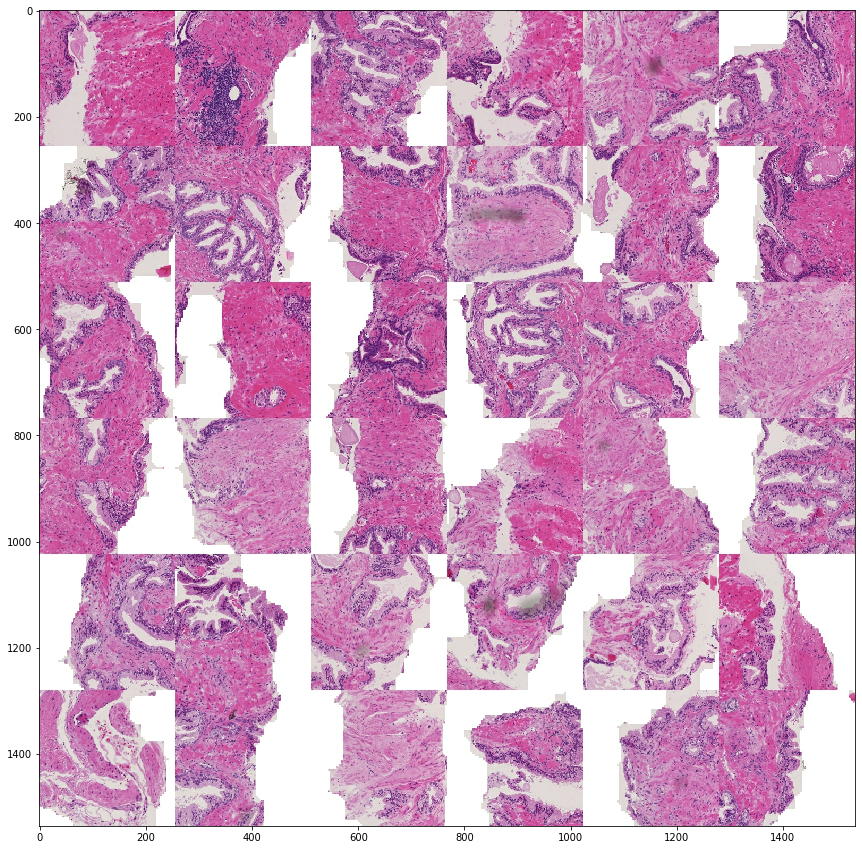

In [43]:
plt.figure(figsize=(15,15))
plt.imshow(image.numpy())